In [137]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import torch
import matplotlib.pyplot as plt
import numpy as np
import os
import io

from dlrep.ImageCaptioning.utils import utilities, SaveModel, inference, VizAttention, VizModel
from dlrep.ImageCaptioning.utils.dataload import String2Int, load_meta
from dlrep.ImageCaptioning.models import ShowAttendTell

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

In [4]:
train_meta = load_meta('./data/metadata/train_meta.json')
train_paths = ['./data'+path for path in train_meta['paths']]
valid_meta = load_meta("./data/metadata/valid_meta.json")
valid_paths = ['./data'+path for path in valid_meta['paths']]

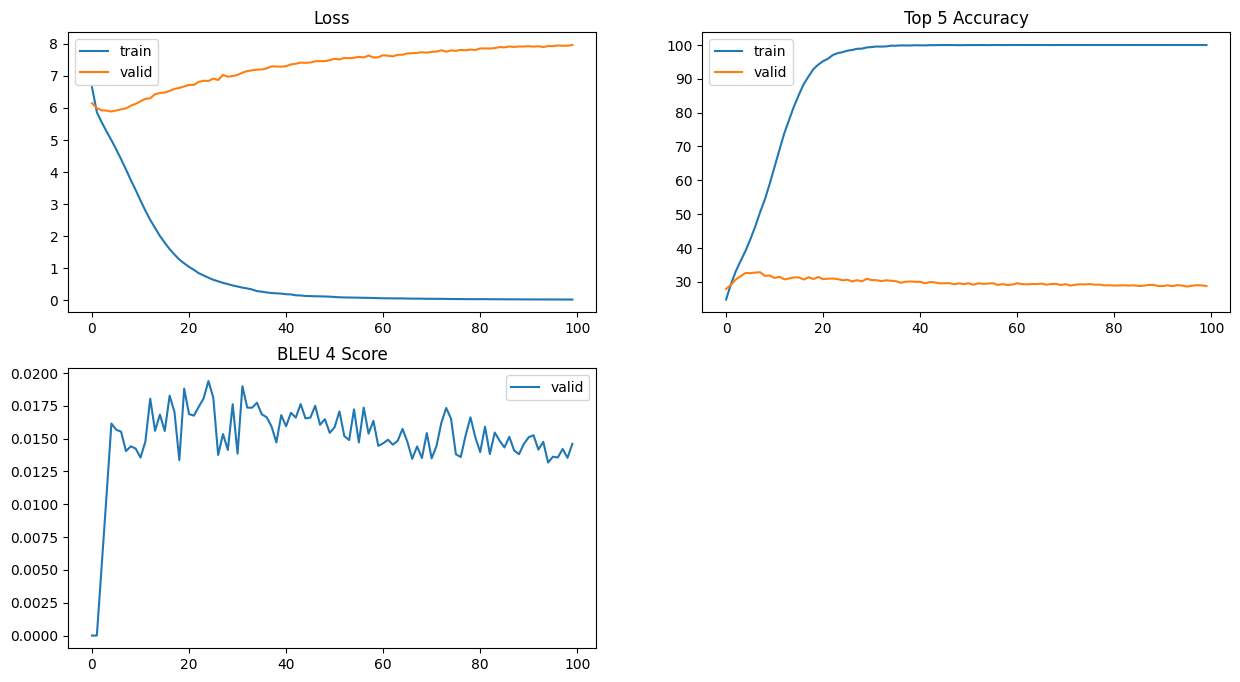

In [5]:
losses = utilities.load_MetricLog("./logs/losses.txt")
val_losses = utilities.load_MetricLog("./logs/val_losses.txt")
top5acc = utilities.load_MetricLog("./logs/top5acc.txt")
val_top5acc = utilities.load_MetricLog("./logs/val_top5acc.txt")
bleu4 = utilities.load_MetricLog("./logs/bleu4.txt")

plt.figure(figsize=(15, 8))

plt.subplot(221)
plt.title("Loss")
plt.plot(losses, label="train")
plt.plot(val_losses, label="valid")
plt.legend()

plt.subplot(222)
plt.title("Top 5 Accuracy")
plt.plot(top5acc, label="train")
plt.plot(val_top5acc, label="valid")
plt.legend()

plt.subplot(223)
plt.title("BLEU 4 Score")
plt.plot(bleu4, label="valid")
plt.legend()

plt.show()

In [6]:
CHECKPOINT = "./checkpoints/best_mod_100eps.tar"
state_dicts, meta = SaveModel.load_checkpoint(CHECKPOINT)

string2int = String2Int(saved_dict=meta['string2int_dict'])
config = meta['config']
print(f"best epoch = {meta['info']['epoch']}")
print(f"bleu4 score = {meta['info']['bleu4']}")

best epoch = 24
bleu4 score = 0.019391918296901536


In [89]:
encoder = ShowAttendTell.Encoder(weights='random')
encoder.finetune(config['enc_finetune'])
decoder = ShowAttendTell.AttentionDecoder(config['dec_embed_dim'], config['dec_hidden_dim'], config['attention_dim'], string2int)
encoder.load_state_dict(state_dicts['encoder'])
decoder.load_state_dict(state_dicts['decoder'])

<All keys matched successfully>

In [90]:
encoder = encoder.to(device)
decoder = decoder.to(device)

encoder.eval()
decoder.eval();

In [91]:
imn = 70
image = inference.load_prep_image(valid_paths[imn], transforms=encoder.transforms).to(device)
image_notransform = inference.load_prep_image(valid_paths[imn], transforms=None)

In [92]:
caption, final_seq, bleu4, final_alpha = inference.beam_caption(image, encoder, decoder, string2int, beam_size=3)
print(caption)

illustration of a pink pink with flowers


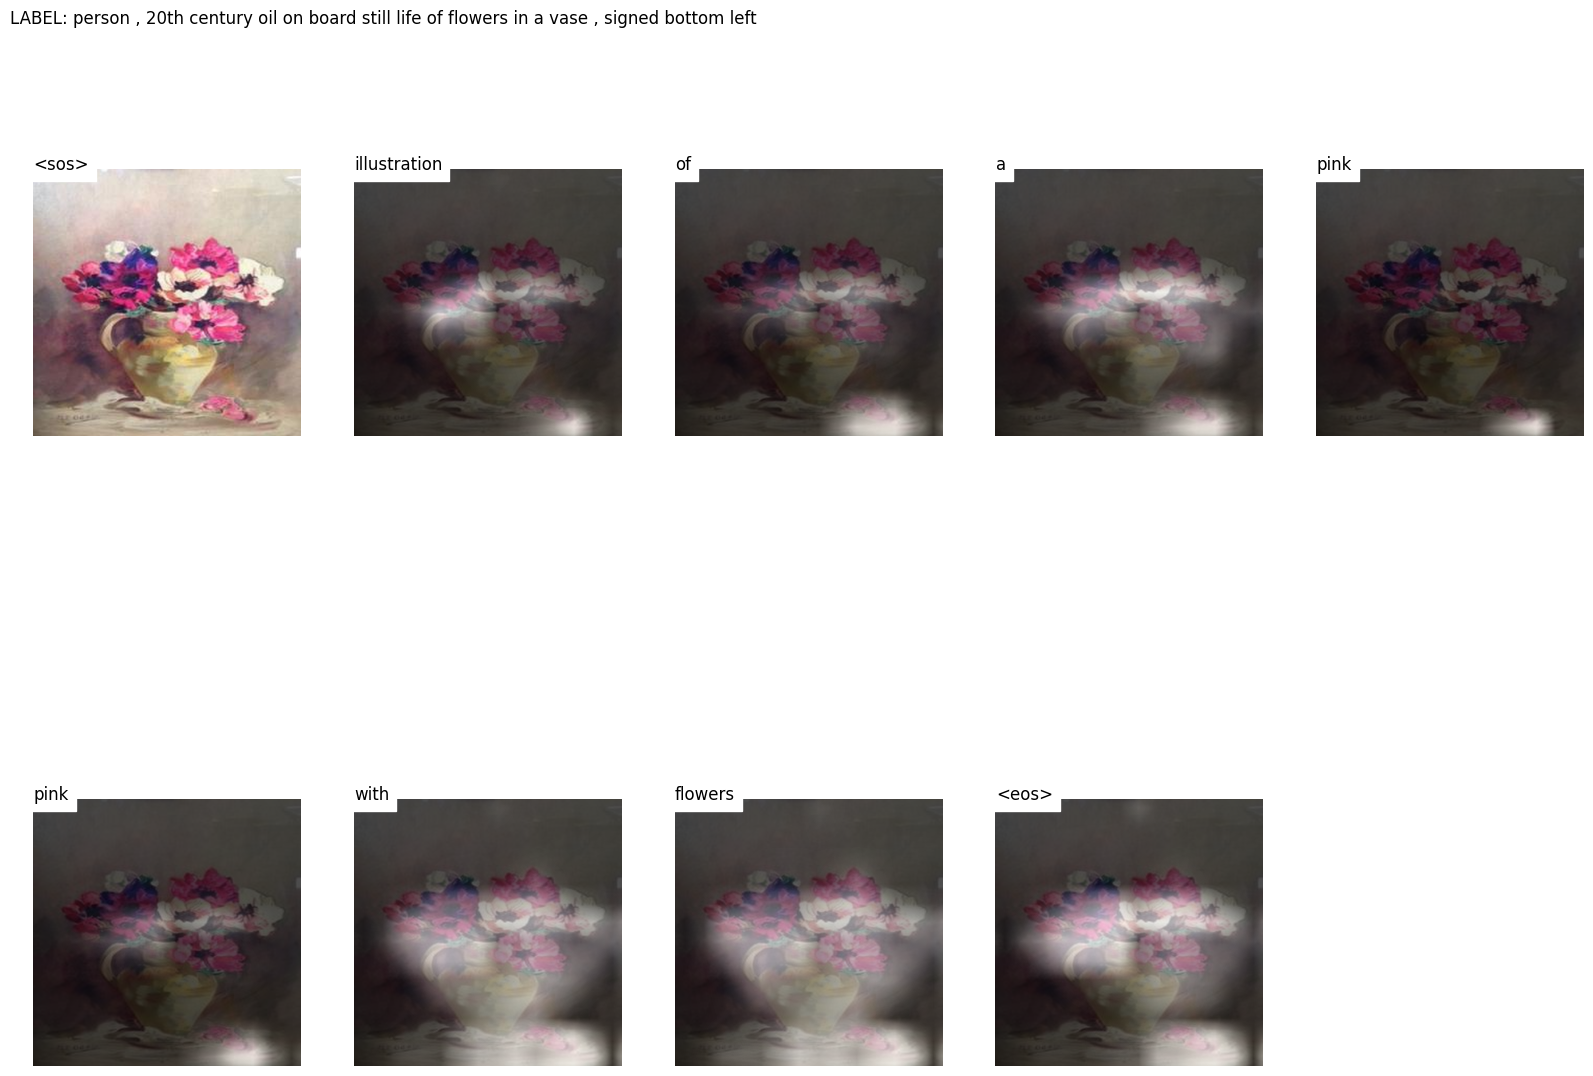

In [93]:
plt.figure(figsize=(20, 15))
VizAttention.plot_predicted(image_notransform, final_seq, final_alpha, string2int, smooth=False)
plt.suptitle("LABEL: "+valid_meta['labels'][imn], x=0.3, y=0.9)
plt.show()

# Inspect Gradients & Weights

In [167]:
plt.figure(figsize=(8,4))
VizModel.plot_bars(decoder, grads=False, y_ax_max="mean_average")

In [168]:
VizModel.plot_density(decoder, grads=False, print_info=True, 
                        exclude=["bias", "attention"])

layer 4 (output_embed): mean +0.000033, std 7.047303e-02
layer 5 (rnn_decode): mean +0.005212, std 3.983438e-02
layer 6 (rnn_decode): mean -0.000199, std 3.426988e-02
layer 9 (    f_beta): mean +0.000086, std 3.686112e-02
layer 11 (   fc_head): mean -0.001087, std 8.793879e-02
layer 13 (    init_h): mean -0.000423, std 3.526581e-02
layer 15 (    init_c): mean -0.000184, std 3.744983e-02


In [170]:
VizModel.plot_density(encoder, print_info=True, 
                        exclude=['bias', 'bn'], start_layer=130, end_layer=150)

layer 132 (resnet.7.0.conv2): mean -0.001791, std 2.865590e-02
layer 135 (resnet.7.0.conv3): mean -0.003592, std 3.976689e-02
layer 138 (resnet.7.0.downsample.0): mean -0.001306, std 2.956014e-02
layer 139 (resnet.7.0.downsample.1): mean +2.627550, std 4.311840e-01
layer 141 (resnet.7.1.conv1): mean -0.003285, std 3.203141e-02
layer 144 (resnet.7.1.conv2): mean -0.002203, std 2.618157e-02
layer 147 (resnet.7.1.conv3): mean -0.003893, std 3.586248e-02
layer 150 (resnet.7.2.conv1): mean -0.003734, std 3.118082e-02


In [172]:
# pop-out plots to inspect each layer's weight distribution
%matplotlib tk
VizModel.plot_density_interactive(decoder, print_info=True, 
                                    exclude=['bias', 'bn'], start_layer=0)